In [1]:
import glob
import pickle
import glob
###
import numpy as np
import pandas as pd
import configparser as cnfp
import matplotlib.pyplot as plt
###
from SeisRoutine import plot as srp
from importlib import reload
from seisbench.util.annotations import PickList

In [2]:
config_path = 'config.ini'
config = cnfp.ConfigParser(interpolation=cnfp.ExtendedInterpolation())
config.read(config_path)

['config.ini']

In [3]:
residual_name_pattern = config.get('File.Name.Pattern', 'residual')
path_residuals = config.get('Path', 'residuals')
path_picks = config.get('Path', 'picks')
city = Data_name = config.get('General', 'name')
path_plot = config.get('Path', 'plots')
residuals_threshold = config.get('Params', 'residuals_threshold_2')
residuals_threshold = int(residuals_threshold)

In [4]:
ylim = [-residuals_threshold, residuals_threshold]
xlim = [0, 100]
model = ['EQTransformer', 'PhaseNet'][0]
num = {}

In [5]:
lst_pickle_files = glob.glob(f'{path_residuals}/*{model}*')
lst_df = [pd.read_pickle(fname) for fname in lst_pickle_files]
df_all = pd.concat(lst_df)
num['catalog-picks'] = df_all.shape[0]

In [6]:
df_result = df_all.copy()
df_result = df_result[~df_result['cat_arrival'].isna()]
df_result = df_result.reset_index()
df_result.rename(columns={'index': 'id'}, inplace=True)
target = df_result['residual'].apply(lambda x: abs(x)<residuals_threshold)

In [7]:
msk_not_detected = df_result['residual'].apply(lambda x: len(x)==0)
df_not_detected = df_result[msk_not_detected]
num['undetected'] = df_not_detected.shape[0]

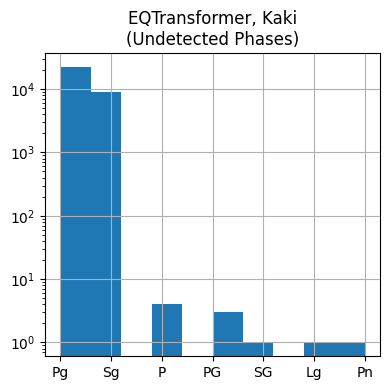

In [8]:
_ = df_not_detected['cat_pick'].apply(lambda x: x.phase_hint).hist(log=True, figsize=(4, 4))
_ = plt.title(f'{model}, {Data_name}\n(Undetected Phases)')
plt.tight_layout()
plt.savefig(f'{path_plot}/{model}-{Data_name}_(Undetected).png')

In [9]:
# pd.options.mode.chained_assignment = None
# df_result = df_result[~df_result['cat_arrival'].isna()]
df_result['distance'] = df_result['cat_arrival'].apply(lambda x: x.distance) * 111
df_result['phase'] = df_result['cat_pick'].apply(lambda x: x.phase_hint[0].upper())

In [10]:
msk_unique = df_result['residual'].apply(lambda x: len(x)==1)
df_unique_detected = df_result[msk_unique]
df_unique_detected = df_unique_detected.explode(['residual'])
df_unique_detected = df_unique_detected.reset_index()
num['Unique'] = df_unique_detected.shape[0]

Saved figure to /media/ekarkooti/ext4/Kahbasi/PhD/DL-evaluation/AutoPicks-CPU_Kaki_20240611T112113/Plots/EQTransformer-Kaki-P_(Unique).png
Saved figure to /media/ekarkooti/ext4/Kahbasi/PhD/DL-evaluation/AutoPicks-CPU_Kaki_20240611T112113/Plots/EQTransformer-Kaki-S_(Unique).png


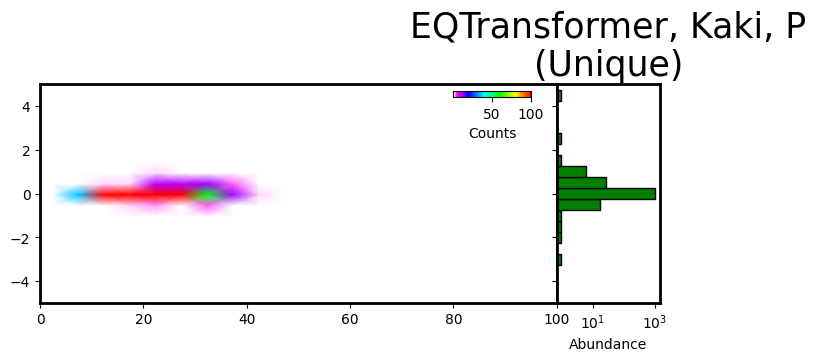

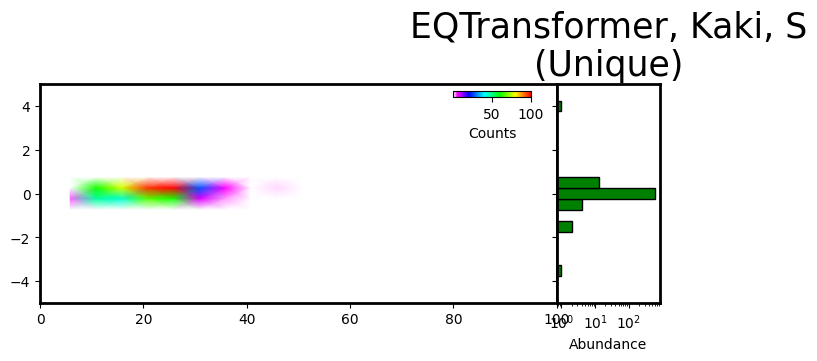

In [11]:
for phasetype in ['P', 'S']:
    phases = df_unique_detected['phase'].to_numpy()
    msk = phases==phasetype
    #
    phases = phases[msk]
    distance = df_unique_detected['distance'][msk].to_numpy()
    residual = df_unique_detected['residual'][msk].to_numpy()
    srp.density_hist(distance, residual,
                    xstep=5, ystep=0.5, histlog=True, kind='density',
                    xlim=xlim, ylim=ylim, xlimhist=[None, 1e5],
                    figsize=(8, 3),
                    hue=phases, vmax=100,
                    title=f'{model}, {Data_name}, {phasetype}\n(Unique)',
                    save=True,
                    savefile=f'{path_plot}/{model}-{Data_name}-{phasetype}_(Unique).png')

In [12]:
msk_at_least = df_result['residual'].apply(lambda x: len(x)>1)
# df_multi_detected = df_multi_detected.reset_index()
df_at_least = df_result[msk_at_least]
num['multiple'] = df_at_least.shape[0]

df_at_least = df_at_least.explode(['residual'])
df_at_least = df_at_least.reset_index()

num['DL-picker'] =  df_at_least.shape[0] + df_unique_detected.shape[0]

Saved figure to /media/ekarkooti/ext4/Kahbasi/PhD/DL-evaluation/AutoPicks-CPU_Kaki_20240611T112113/Plots/EQTransformer-Kaki-P_(Multiple).png
Saved figure to /media/ekarkooti/ext4/Kahbasi/PhD/DL-evaluation/AutoPicks-CPU_Kaki_20240611T112113/Plots/EQTransformer-Kaki-S_(Multiple).png


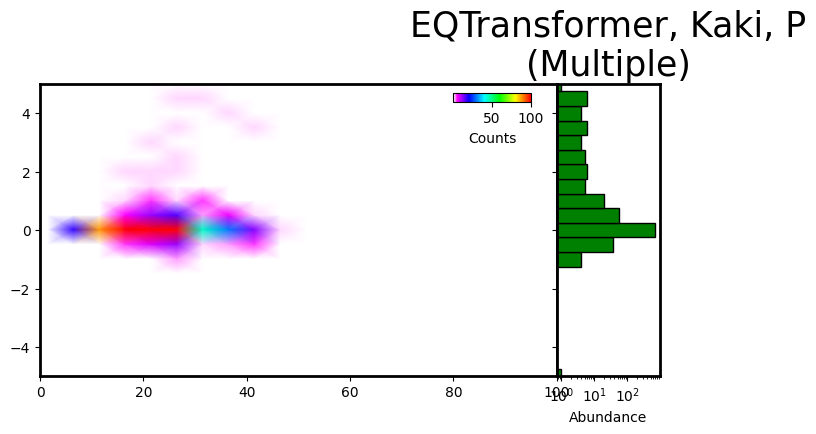

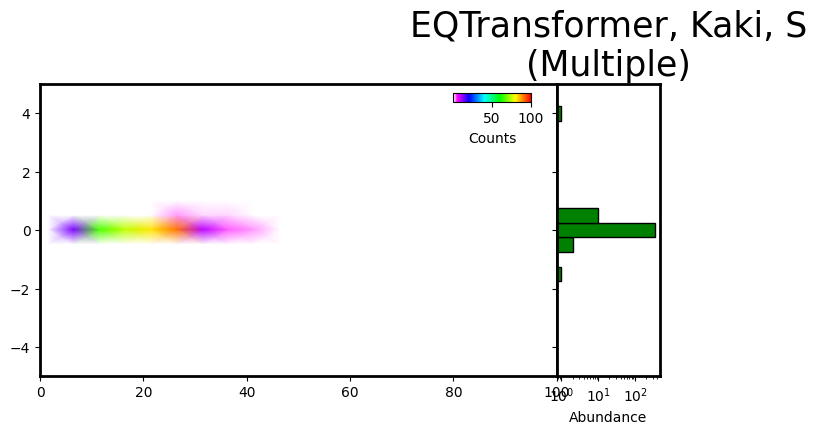

In [13]:
reload(srp)
for phasetype in ['P', 'S']:
    phases = df_at_least['phase'].to_numpy()
    msk = phases==phasetype
    #
    phases = phases[msk]
    distance = df_at_least['distance'][msk].to_numpy()
    residual = df_at_least['residual'][msk].to_numpy()
    srp.density_hist(distance, residual,
                    xstep=5, ystep=0.5, histlog=True, kind='density',
                    xlim=xlim, ylim=ylim, xlimhist=[None, 1e5],
                    figsize=(8, 4),
                    hue=phases, vmax=100,
                    title=f'{model}, {Data_name}, {phasetype}\n(Multiple)',
                    save=True,
                    savefile=f'{path_plot}/{model}-{Data_name}-{phasetype}_(Multiple).png')

{'catalog-picks': 34445, 'undetected': 31510, 'Unique': 1785, 'multiple': 1150, 'DL-picker': 4526}
RangeIndex(start=0, stop=2, step=1)


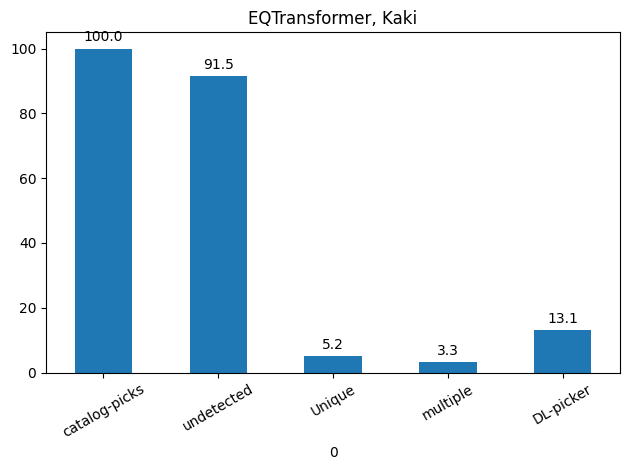

In [14]:
print(num)
df_num = pd.DataFrame(num.items())
df_num[1] = round(df_num[1] / num['catalog-picks'] * 100, 1)
print(df_num.keys())
plots = df_num.plot(x=0, y=1, kind='bar', log=False, legend=False,
                    title=f'{model}, {Data_name}', rot=30)

for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.1f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
plt.tight_layout()
plt.savefig(f'{path_plot}/{model}-{Data_name}_(Number).png')

All Picks

In [17]:
bins = np.arange(0, 1.05, 0.05)

for model in ['EQTransformer', 'PhaseNet']:
    lst_file = glob.glob(f'{path_picks}/*{model}*.pickle')
    picks = PickList()
    l = len(lst_file)
    print(f'{model}-{city}')
    for indx, fname in enumerate(lst_file):
        print(indx, 'of', l, end=', ')
        with open(fname, 'rb') as fileObj:
            classified = pickle.load(fileObj)
            picks += classified.picks
    w = [pick.peak_value for pick in picks]
    for log in [True, False]:
        plt.hist(w, edgecolor='k', bins=bins, log=log)
        plt.title(f'{model}, {city}, {log=}')
        plt.savefig(f'{path_plot}/weights-{model}-{city}-{log}.png')
        plt.close('all')

EQTransformer-Kaki
0 of 47, 1 of 47, 2 of 47, 3 of 47, 4 of 47, 5 of 47, 6 of 47, 7 of 47, 8 of 47, 9 of 47, 10 of 47, 11 of 47, 12 of 47, 13 of 47, 14 of 47, 15 of 47, 16 of 47, 17 of 47, 18 of 47, 19 of 47, 20 of 47, 21 of 47, 22 of 47, 23 of 47, 24 of 47, 25 of 47, 26 of 47, 27 of 47, 28 of 47, 29 of 47, 30 of 47, 31 of 47, 32 of 47, 33 of 47, 34 of 47, 35 of 47, 36 of 47, 37 of 47, 38 of 47, 39 of 47, 40 of 47, 41 of 47, 42 of 47, 43 of 47, 44 of 47, 45 of 47, 46 of 47, PhaseNet-Kaki
0 of 47, 1 of 47, 2 of 47, 3 of 47, 4 of 47, 5 of 47, 6 of 47, 7 of 47, 8 of 47, 9 of 47, 10 of 47, 11 of 47, 12 of 47, 13 of 47, 14 of 47, 15 of 47, 16 of 47, 17 of 47, 18 of 47, 19 of 47, 20 of 47, 21 of 47, 22 of 47, 23 of 47, 24 of 47, 25 of 47, 26 of 47, 27 of 47, 28 of 47, 29 of 47, 30 of 47, 31 of 47, 32 of 47, 33 of 47, 34 of 47, 35 of 47, 36 of 47, 37 of 47, 38 of 47, 39 of 47, 40 of 47, 41 of 47, 42 of 47, 43 of 47, 44 of 47, 45 of 47, 46 of 47, 

In [ ]:
# stname_lst = list({pick.trace_id for pick in picks})

In [ ]:
# import numpy as np
# for stname in stname_lst:
#     for phase in ['P', 'S']:
#         st_picks = picks.select(trace_id=stname, phase=phase)
#         t = [pick.peak_time for pick in st_picks]
#         t = sorted(t)
#         t = np.diff(t)
#         plt.hist(t[t<100000], log=False, edgecolor='k', density=True, bins=np.arange(0, 100, 1))
#         plt.title(stname + phase)
#         plt.show()
#         break
#     break